# 0. Importing Packages

In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm
import init_cfg as ic

# 1. Loading IFU Data

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var, cont
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
binned_continuum = vb['cont']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [3]:
binned_spectrum.shape

(4591, 431)

In [4]:
data0 = binned_spectrum - binned_continuum
vari0 = binned_variance
cont0 = binned_continuum

dat = data0 * (1.0+redshift)
var = vari0 * (1.0+redshift)**2.0
cont = cont0 * (1.0+redshift)

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [5]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.1*np.sum((binNpix == 1)))
print(0.1*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 1.1. Retrieving maximum spectrum

In [6]:
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)
# yInd2, xInd2 = 30, 38    # non-contaminated region
n_bin = data_vbin[yInd, xInd]
print("Maximum intensity bin")
print(f"Bin {n_bin:d}: (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = dat[:, n_bin]
maximum_variance = var[:, n_bin]
maximum_continuum = cont[:, n_bin]

Maximum intensity bin
Bin 0: (x, y) = (32, 29)


## 1.2. Retrieving integrated spectrum with the bin's order

In [7]:
n_integrate = 16
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

## 1.3. Retrieving integrated spectrum within a circle

In [8]:
fin_cb = 'bfcube_3D.fits'

d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

d_sci[:, 0, :] = 0.
d_sci[:, :, 0] = 0.
d_sci[:, -1, :] = 0.
d_sci[:, :, -1] = 0.

d_sci2 = d_sci * (1+redshift)
d_var2 = d_var * (1+redshift)**2

In [9]:
from photutils.aperture import CircularAperture as CAp
rad = 4
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci2*msk, axis=(1, 2))
circular_variance = np.sum(d_var2*msk, axis=(1, 2))
print(circular_spectrum.shape)

Area: 50.2655 = 50.2655?  True
(4591,)


<IPython.core.display.Javascript object>


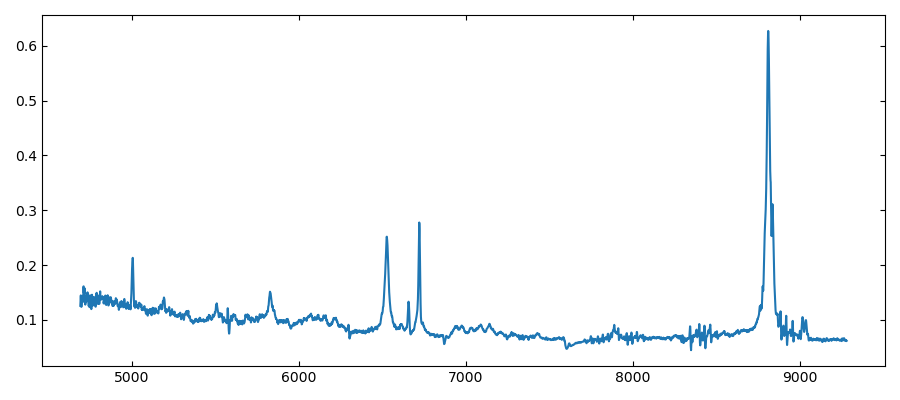

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, circular_spectrum)
plt.tight_layout()

### 1.3.1. Continuum subtraction for the circular spectrum

<IPython.core.display.Javascript object>


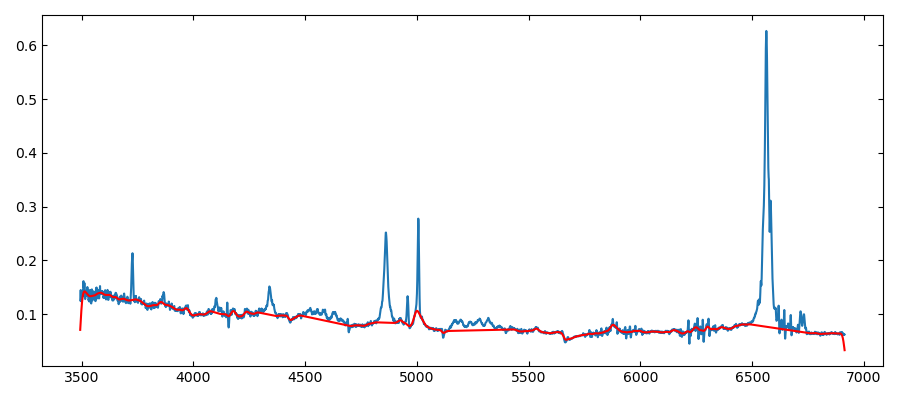

In [11]:
# ----- Continuum fitting ----- #
cont_width = 5  # AA
kernel_width = 10  # AA
sig1, sig2 = 3.0, 4.0  # For sigma clipping

# Wavelength masking range (copied from contfit_init.ipynb)
wav_msk = np.array([[4990, 5015],  # [OII]
                    [5175, 5200],   # [NeIII]
                    [5470, 5540],   # H delta
                    [5750, 5875],   # H gamma
                    [6000, 6320],   # noisy? region
                    [6470, 6580],   # H beta
                    [6645, 6665],   # [OIII]4959
                    [6710, 6730],   # [OIII]5007
                    [6900, 7300],   # noisy? region
                    [8700, 9075]])   # [NII] + H alpha + [SII]6717/31

# Interpolation
spec_int = copy.deepcopy(circular_spectrum)
for j in np.arange(wav_msk.shape[0]):
    spx_l = np.abs(wav_obs - wav_msk[j,0]).argmin()
    spx_r = np.abs(wav_obs - wav_msk[j,1]).argmin()

    c_l, lo_l, up_l = sigmaclip(spec_int[spx_l-round(cont_width/ic.wav_intv):spx_l], sig1, sig1)  # 20 AA
    c_r, lo_r, up_r = sigmaclip(spec_int[spx_r+1:spx_r+1+round(cont_width/ic.wav_intv)], sig1, sig1)  # 20 AA

    cont_l = c_l.mean()
    cont_r = c_r.mean()

#     spec_int[spx_l:spx_r+1] = 0.5*(cont_l + cont_r)
    spec_int[spx_l:spx_r+1] = cont_l + \
    ((cont_r-cont_l)/(wav_obs[spx_r]-wav_obs[spx_l]))*(wav_obs[spx_l:spx_r+1]-wav_obs[spx_l])

# Sigma clipping
clipped, lower, upper = sigmaclip(spec_int, sig2, sig2)
spec_int_clipped = copy.deepcopy(spec_int)
spec_int_clipped[spec_int < lower] = clipped.mean()
spec_int_clipped[spec_int > upper] = clipped.mean()

# Smoothing spectra
g = Gaussian1DKernel(stddev = round(kernel_width/ic.wav_intv))  # 10 AA
spec_filt = convolve(spec_int_clipped, g)  # spec_int OR spec_int_clipped

# Plotting & saving results
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, circular_spectrum)
ax.plot(wav_res, spec_filt, '-', color='red')
plt.tight_layout()
plt.savefig("subcircular_0.png", dpi=300)

subcircular_spectrum = circular_spectrum - spec_filt
subcircular_variance = circular_variance
subcircular_continuum = spec_filt

In [12]:
mode = "maximum"
# "maximum" OR "integrated" OR "subcircular"

exec("fit_spectrum = copy.deepcopy("+mode+"_spectrum)")
exec("fit_variance = copy.deepcopy("+mode+"_variance)")
exec("fit_continuum = copy.deepcopy("+mode+"_continuum)")

<IPython.core.display.Javascript object>


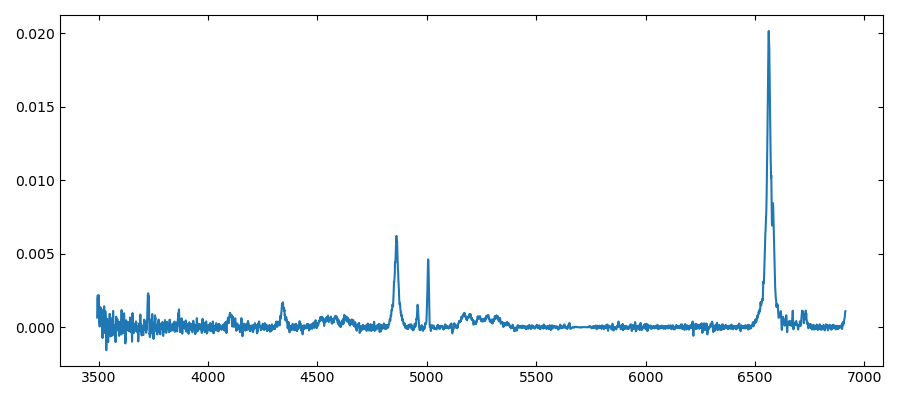

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, fit_spectrum)
plt.tight_layout()

# 2. Basic Setting of Line Fitting

In [14]:
np.random.seed(0)
maxfev = 2000

In [15]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multin_gauss_cdf_scale(x, *pars, n=2, n_broad=0):
    g_i = 0
    for i in np.arange(n):
        if (i < n-n_broad):
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        else:
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[2*i+2], pars[2*i+3])
    return g_i

In [16]:
def line_par(line_numbers, broad_component = False):

    if (line_numbers == 0):
        nlines, nbroad = 1, 0  # 2, 0
        line_names = ['OII3727']#, 'OII3729']
        line_wav = [3727.092]#, 3729.875]
        line_sigma = [3.0]
        wav_fit = [3720.0, 3740.0]
    
    if (line_numbers == 1):
        if broad_component:
            nlines, nbroad = 2, 1
            line_names = ['Hbeta', 'Broad1_1']
            line_wav = [4862.68, 4862.68]
            line_sigma = [3.0, 20.0]
            wav_fit = [4810.0, 4910.0]
        else:
            nlines, nbroad = 1, 0
            line_names = ['Hbeta']
            line_wav = [4862.68]
            line_sigma = [3.0]
            wav_fit = [4855.0, 4870.0]

    if (line_numbers == 2):
        if broad_component:
            nlines, nbroad = 3, 1
            line_names = ['OIII4959', 'OIII5007', 'Broad2_1']
            line_wav = [4960.295, 5008.240, 5008.240]
            line_sigma = [3.0, 20.0]
            wav_fit = [4940.0, 5040.0]
        else:    
            nlines, nbroad = 2, 0
            line_names = ['OIII4959', 'OIII5007']
            line_wav = [4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4950.0, 5015.0]        

    if (line_numbers == 3):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1']
            line_wav = [6549.86, 6564.61, 6585.27, 6564.61]
            line_sigma = [3.0, 30.0]
            wav_fit = [6500.0, 6625.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['NII6548', 'Halpha', 'NII6584']
            line_wav = [6549.86, 6564.61, 6585.27]
            line_sigma = [3.0]
            wav_fit = [6540.0, 6595.0]

    if (line_numbers == 4):
        nlines, nbroad = 2, 0
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        line_sigma = [3.0]
        wav_fit = [6710.0, 6740.0]

    if (line_numbers == 5):
        nlines, nbroad = 1, 0
        line_names = ['OI6300']
        line_wav = [6302.046]
        line_sigma = [3.0]
        wav_fit = [6295.0, 6310.0]
    
    line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)
    
    return [nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq\n')
f.close()

broad = True
if broad:
    g = open('linefit_integrated_broad.txt','w')
    g.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq flxsum_scale\n')
    g.close()

# 3. Emission Line Fitting

## 3.1. ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

100%|██████████| 1000/1000 [00:20<00:00, 49.58it/s]

----- Narrow components -----
NII6548 mean: 6548.883 +/- 0.650 Angstrom
NII6548 sigma: 283.31 +/- 4.792 km/s
NII6548 sigma: 6.189 +/- 0.105 Angstrom
NII6548 R: 1197.30 +/- 44.72
NII6548 flux: 5.06e-02 +/- 4.15e-03
NII6548 reduced chi-square: 0.31


Halpha mean: 6563.529 +/- 0.119 Angstrom
Halpha sigma: 283.31 +/- 4.792 km/s
Halpha sigma: 6.203 +/- 0.105 Angstrom
Halpha R: 1199.99 +/- 44.78
Halpha flux: 2.61e-01 +/- 7.32e-03
Halpha reduced chi-square: 0.94


NII6584 mean: 6581.487 +/- 0.228 Angstrom
NII6584 sigma: 283.31 +/- 4.792 km/s
NII6584 sigma: 6.220 +/- 0.105 Angstrom
NII6584 R: 1203.29 +/- 44.85
NII6584 flux: 8.42e-02 +/- 3.71e-03
NII6584 reduced chi-square: 1.03


----- Broad components -----
Broad3_1 mean: 6562.000 +/- 0.839 Angstrom
Broad3_1 sigma: 1451.22 +/- 71.489 km/s
Broad3_1 sigma: 31.765 +/- 1.565 Angstrom
Broad3_1 R: 1199.71 +/- 44.77
Broad3_1 flux: 2.11e-01 +/- 1.19e-02
Broad3_1 reduced chi-square: 0.55




<IPython.core.display.Javascript object>


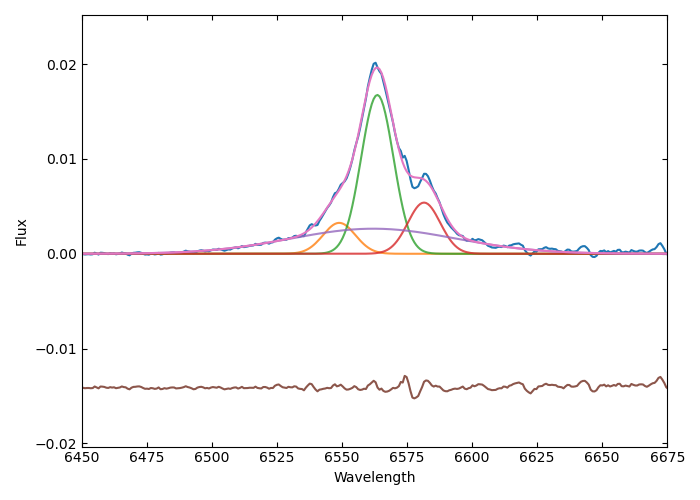

[8.78905076e+00 4.84076182e-03 2.10586291e-01]


In [17]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()
    
    
# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.2. ${\rm [SII]\lambda\lambda6717,6731}$

100%|██████████| 1000/1000 [00:02<00:00, 374.08it/s]

----- Narrow components -----
SII6717 mean: 6716.782 +/- 0.501 Angstrom
SII6717 sigma: 182.15 +/- 14.942 km/s
SII6717 sigma: 4.081 +/- 0.335 Angstrom
SII6717 R: 1228.11 +/- 45.40
SII6717 flux: 1.15e-02 +/- 9.67e-04
SII6717 reduced chi-square: 0.08


SII6731 mean: 6731.465 +/- 0.542 Angstrom
SII6731 sigma: 182.15 +/- 14.942 km/s
SII6731 sigma: 4.090 +/- 0.335 Angstrom
SII6731 R: 1230.81 +/- 45.46
SII6731 flux: 1.05e-02 +/- 9.64e-04
SII6731 reduced chi-square: 0.14




<IPython.core.display.Javascript object>


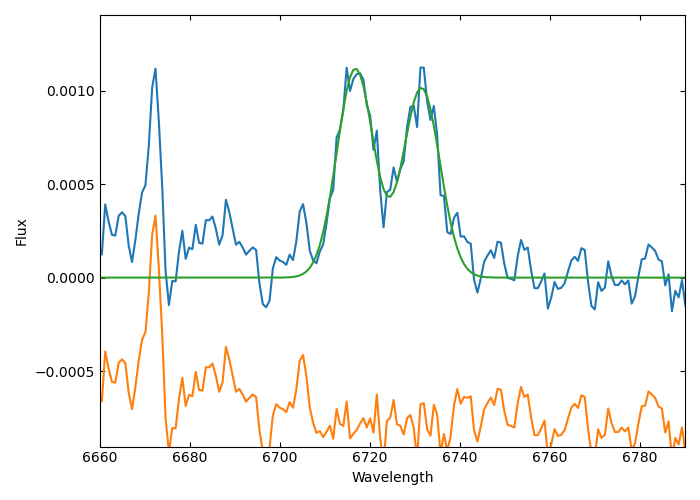

[8.78905076e+00 4.84076182e-03 2.10586291e-01]


In [18]:
# Line fitting: Monte Carlo simulation of curve_fit ([SII]6717/6731)
line_numbers = 4

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.3. ${\rm [OII]\lambda\lambda3727,3729}$

100%|██████████| 1000/1000 [00:02<00:00, 481.60it/s]

----- Narrow components -----
OII3727 mean: 3726.850 +/- 1.506 Angstrom
OII3727 sigma: 205.40 +/- 74.546 km/s
OII3727 sigma: 2.553 +/- 0.927 Angstrom
OII3727 R: 679.44 +/- 34.71
OII3727 flux: 1.73e-02 +/- 7.72e-03
OII3727 reduced chi-square: 0.12




<IPython.core.display.Javascript object>


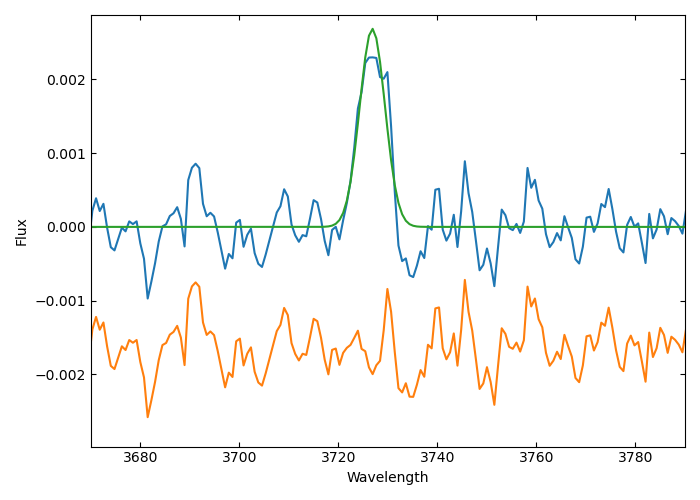

[8.78905076e+00 4.84076182e-03 2.10586291e-01]


In [19]:
# Line fitting: Monte Carlo simulation of curve_fit ([OII]3727/3729)
line_numbers = 0

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.4. ${\rm H\beta}$

100%|██████████| 1000/1000 [00:07<00:00, 137.40it/s]

----- Narrow components -----
Hbeta mean: 4861.950 +/- 0.450 Angstrom
Hbeta sigma: 329.20 +/- 71.486 km/s
Hbeta sigma: 5.339 +/- 1.159 Angstrom
Hbeta R: 887.74 +/- 38.37
Hbeta flux: 4.43e-02 +/- 1.77e-02
Hbeta reduced chi-square: 0.24


----- Broad components -----
Broad1_1 mean: 4859.623 +/- 1.541 Angstrom
Broad1_1 sigma: 957.09 +/- 172.296 km/s
Broad1_1 sigma: 15.514 +/- 2.793 Angstrom
Broad1_1 R: 887.31 +/- 38.36
Broad1_1 flux: 1.06e-01 +/- 1.37e-02
Broad1_1 reduced chi-square: 0.10




<IPython.core.display.Javascript object>


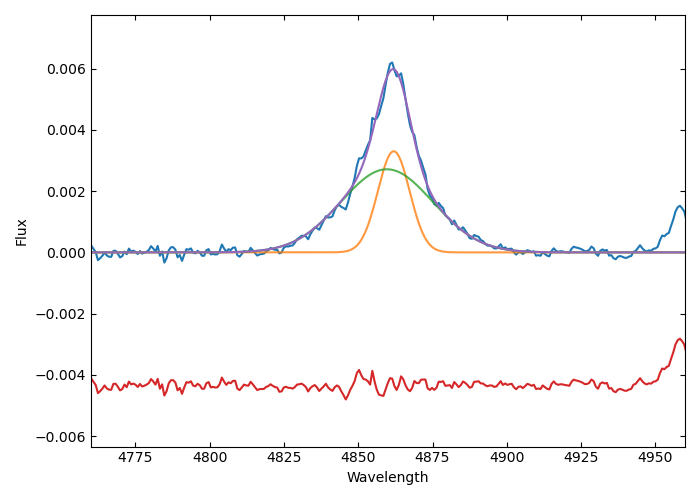

[8.48871624e+00 3.19250077e-03 1.05616473e-01]


In [20]:
# Line fitting: Monte Carlo simulation of curve_fit (H beta)
line_numbers = 1

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.5. ${\rm [OIII]\lambda\lambda4959,5007}$

100%|██████████| 1000/1000 [00:03<00:00, 303.01it/s]


----- Narrow components -----
OIII4959 mean: 4958.072 +/- 0.407 Angstrom
OIII4959 sigma: 196.56 +/- 8.404 km/s
OIII4959 sigma: 3.251 +/- 0.139 Angstrom
OIII4959 R: 905.38 +/- 38.70
OIII4959 flux: 1.19e-02 +/- 1.17e-03
OIII4959 reduced chi-square: 0.13


OIII5007 mean: 5006.237 +/- 0.154 Angstrom
OIII5007 sigma: 196.56 +/- 8.404 km/s
OIII5007 sigma: 3.282 +/- 0.140 Angstrom
OIII5007 R: 914.22 +/- 38.87
OIII5007 flux: 3.77e-02 +/- 1.46e-03
OIII5007 reduced chi-square: 0.28




<IPython.core.display.Javascript object>


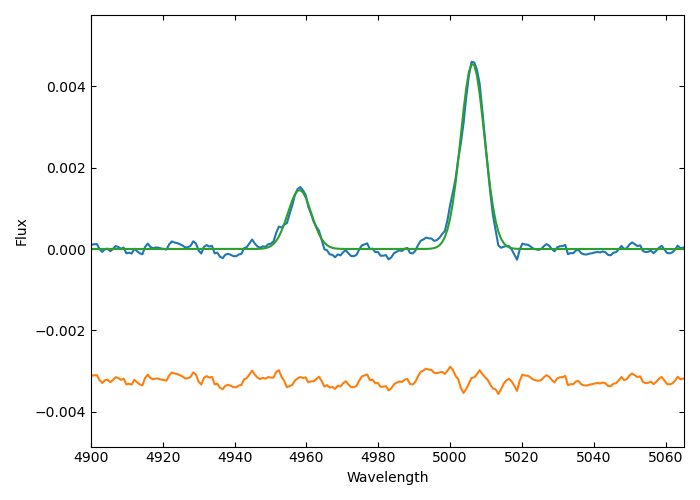

[8.48871624e+00 3.19250077e-03 1.05616473e-01]


In [21]:
# Line fitting: Monte Carlo simulation of curve_fit ([OIII]4959/5007)
line_numbers = 2

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

# 4. Additional Tasks for Broad Components

## 4.1. Creating a New Image with Gaussian Profile

In [22]:
from astropy.modeling.models import Gaussian2D
fwhm = 1.0    # arcsec
pixel_scale = 0.1    # arcsec/pix
x_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
y_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
print(x_sigma, y_sigma)
g2d = Gaussian2D(amplitude = 1, x_mean = yInd, y_mean = xInd, x_stddev = x_sigma, y_stddev = y_sigma)
img_g2d = g2d(*np.mgrid[0:d_sci.shape[1], 0:d_sci.shape[2]])

4.2466090014400955 4.2466090014400955


<IPython.core.display.Javascript object>


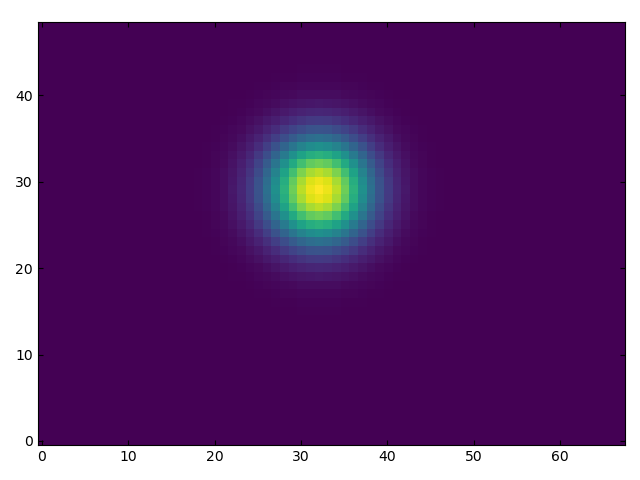

In [23]:
fig, ax = plt.subplots()
ax.imshow(img_g2d, origin = 'lower')
plt.tight_layout()

fits.writeto("g2d.fits", img_g2d, overwrite=True)

## 4.2. Checking for Spectra in an Arbitrary Bin

### 4.2.1. Setting an Arbitrary Bin

In [24]:
nbin = 50    # arbitrary bin

print(f"Bin {nbin:d}")

fit_spectrum = dat[:, nbin]
fit_variance = var[:, nbin]
fit_continuum = cont[:, nbin]

Bin 50


In [25]:
indices = np.argwhere(data_vbin == nbin)
print("The (x,y) indices of the bin")
print(indices)

The (x,y) indices of the bin
[[22 31]]


In [26]:
npix = indices.shape[0]
print(f"Number of pixels in the bin: {npix:d}")

Number of pixels in the bin: 1


### 4.2.2. Creating an Image of Initial Guess for the Broad Component Factors

In [27]:
print("Gaussian factors of this bin:")
img_g2d[indices[:, 0], indices[:, 1]]

Gaussian factors of this bin:


array([0.25])

In [28]:
fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
if (mode == "subcircular"):
    fac /= (np.sum(img_g2d*msk))
print(f"Mean Gaussian factor of broad components: {fac:.4f}")

Mean Gaussian factor of broad components: 0.2500


<IPython.core.display.Javascript object>


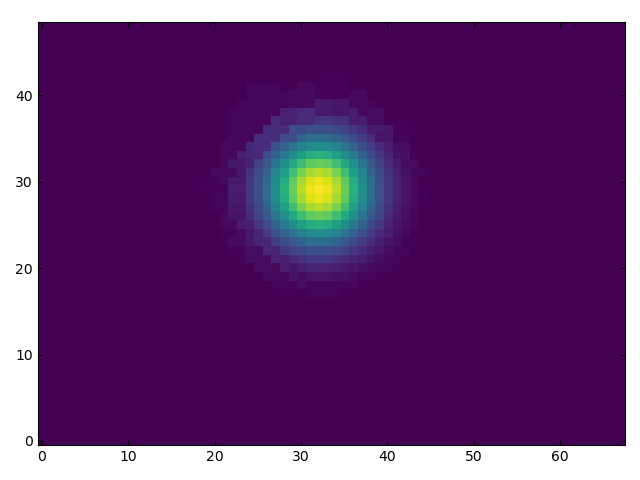

In [29]:
gfac = np.zeros_like(img_g2d)
for b in np.unique(data_vbin):
    binwhere = np.argwhere(data_vbin == b)
    if (b == -99):
        fc = 0.0
    else:
        fc = np.sum(img_g2d[binwhere[:, 0], binwhere[:, 1]])
#         fc = img_g2d[binwhere[:, 0], binwhere[:, 1]].max()
    gfac[data_vbin == b] = fc / binwhere.shape[0]
    
fig, ax = plt.subplots()
ax.imshow(gfac, origin = 'lower', vmin=0.01, vmax=1.0)
plt.tight_layout()
fits.writeto("gfac.fits", gfac, overwrite=True)

### 4.2.3. Plotting the Spectra for Visual Check

<IPython.core.display.Javascript object>


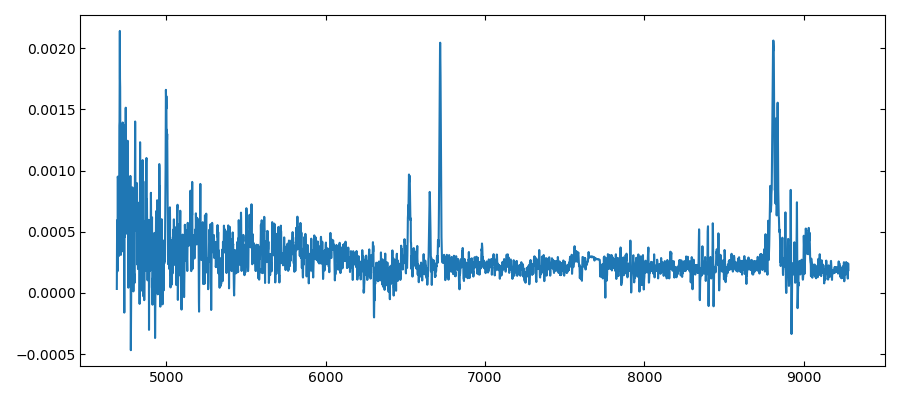

In [30]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

fig, ax = plt.subplots(figsize=(9,4))
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum)
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]))
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2]))
ax.plot(wav_obs, binned_spectrum[:, nbin] / indices.shape[0])
plt.tight_layout()

<IPython.core.display.Javascript object>


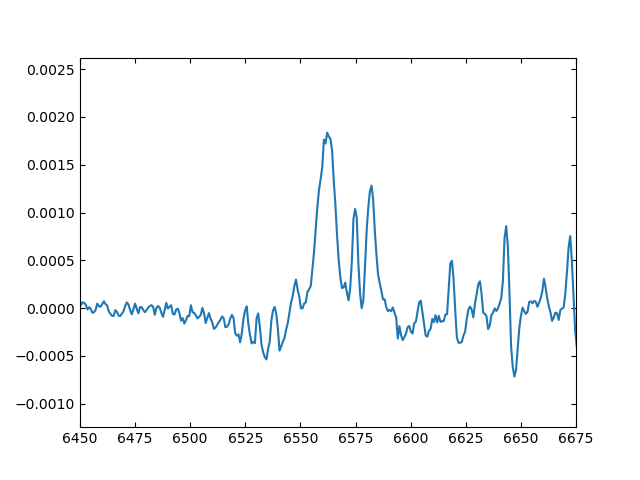

In [31]:
broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - fac*broad_plt)

### 4.2.4. Line Fitting with Fixing Broad Components

0.25000000000000006 ---> 0.0994974321028388 ---> 0.0994974321028388
0.0188747479766887
----- Narrow components -----
NII6548 mean: 6548.045 +/- 1.379 Angstrom
NII6548 sigma: 217.18 +/- 8.772 km/s
NII6548 sigma: 4.744 +/- 0.192 Angstrom
NII6548 R: 1197.15 +/- 44.72
NII6548 flux: 4.50e-03 +/- 9.67e-04
NII6548 reduced chi-square: 0.32


Halpha mean: 6562.051 +/- 0.228 Angstrom
Halpha sigma: 217.18 +/- 8.772 km/s
Halpha sigma: 4.754 +/- 0.192 Angstrom
Halpha R: 1199.72 +/- 44.77
Halpha flux: 2.52e-02 +/- 1.37e-03
Halpha reduced chi-square: 0.51


NII6584 mean: 6580.644 +/- 0.334 Angstrom
NII6584 sigma: 217.18 +/- 8.772 km/s
NII6584 sigma: 4.767 +/- 0.193 Angstrom
NII6584 R: 1203.13 +/- 44.85
NII6584 flux: 1.50e-02 +/- 1.10e-03
NII6584 reduced chi-square: 0.89


----- Broad components -----
Broad3_1 mean: 6562.000 +/- 0.000 Angstrom
Broad3_1 sigma: 1451.22 +/- 0.000 km/s
Broad3_1 sigma: 31.765 +/- 0.000 Angstrom
Broad3_1 R: 1199.71 +/- 44.77
Broad3_1 flux: 2.10e-02 +/- 3.97e-03
Broad3_1 red

<IPython.core.display.Javascript object>


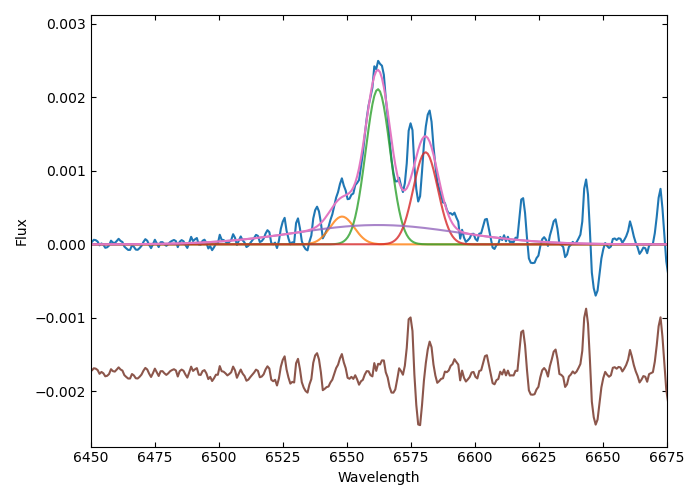

In [32]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_dat = y_loc / indices.shape[0]
flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
y_fit = x_wav * y_dat

broad_fit = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_fit += gauss_cdf_scale(x_fit, *mpar_b)
    

# Model fitting
def line_model2(x, *pars):
    narrow_comp = 0
    for i in np.arange(nlines-nbroad):
        narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
    broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
    return narrow_comp + broad_comp
    
param = [line_sigma[0] / line_wav[0]]
for j in np.arange(nlines-nbroad):
    param += [np.log(line_wav[j]), flx_scale0 / nlines]
param += [fac]

popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
perr = np.sqrt(np.diag(pcov))
mpar, e_mpar = popt, perr


# Arranging parameters
ffac = mpar[-1]
print(fac, "--->", ffac, "--->", ffac*indices.shape[0])
mpar[2::2] *= indices.shape[0]
mpar = list(mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    mpar += [mpar_b[0], mpar_b[1], ffac*mpar_b[2]*indices.shape[0]]

e_ffac = e_mpar[-1]
print(e_ffac)
e_mpar[2::2] *= indices.shape[0]
e_mpar = list(e_mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    e_mpar += [0.0, 0.0, e_ffac*mpar_b[2]*indices.shape[0]]

    
# Printing the results
# f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")

    
# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()

### 4.2.5. Check for Broad-Component-Subtracted Spectra

* ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

<IPython.core.display.Javascript object>


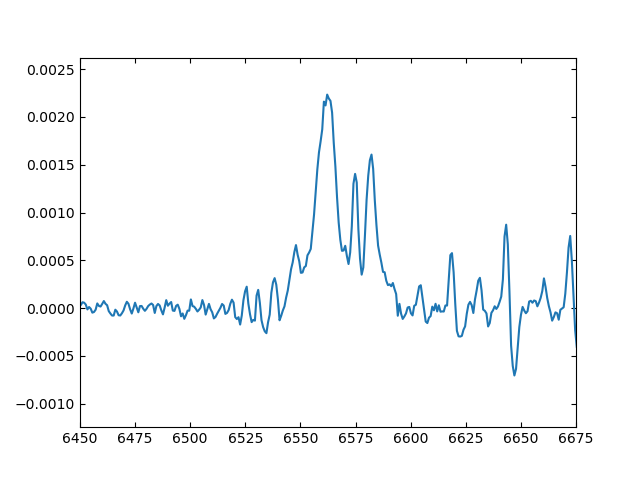

In [33]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

* ${\rm H\beta}$

<IPython.core.display.Javascript object>


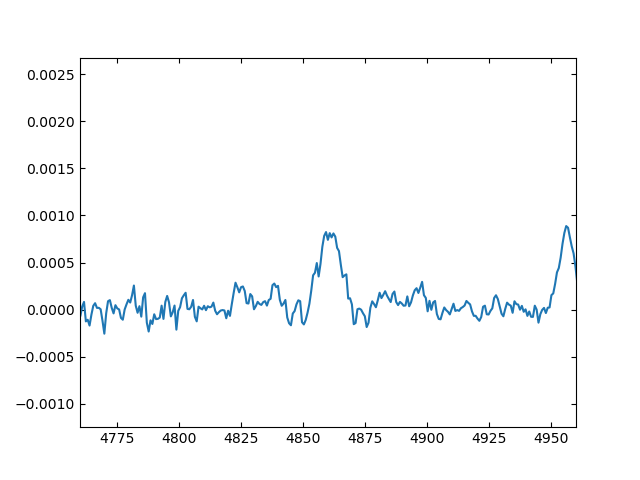

In [34]:
line_numbers = 1
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

## 4.3. Creating the broad component factor map

In [35]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

bfac = np.zeros(binned_spectrum.shape[1])
e_bfac = np.zeros(binned_spectrum.shape[1])
nmax_bin = data_vbin[yInd, xInd]
bfac[nmax_bin], e_bfac[nmax_bin] = 1.0, 0.0
print(f"Maximum - Bin {nmax_bin:d} : {bfac[0]:.3f} +/- {e_bfac[0]:.3f}")

for ibin in np.arange(binned_spectrum.shape[1]):
    fit_spectrum = dat[:, ibin]
    fit_variance = var[:, ibin]
    fac = gfac[data_vbin == ibin][0]
    
    if (ibin == nmax_bin):
        pass
    
    if (fac < 0.01):
        bfac[ibin] = 0.
        e_bfac[ibin] = 0.
    
    elif ((ibin != nmax_bin) & (fac >= 0.01)):
        spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
                   np.abs(wav_res-wav_fit[1]).argmin()]
        x_bin = wav_res[1] - wav_res[0]
        x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
        x_fit = np.log(x_wav)

        y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
        y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
        y_dat = y_loc / indices.shape[0]
        flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
        y_fit = x_wav * y_dat

        broad_fit = 0
        for i in np.arange(nbroad):
            exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
            broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

        # Model fitting
        def line_model2(x, *pars):
            narrow_comp = 0
            for i in np.arange(nlines-nbroad):
                narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
            broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
            return narrow_comp + broad_comp

        param = [line_sigma[0] / line_wav[0]]
        for j in np.arange(nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        param += [fac]
        
        try:
            popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
            perr = np.sqrt(np.diag(pcov))
            
            bfac[ibin] = np.maximum(0.0, popt[-1])*indices.shape[0]
            e_bfac[ibin] = np.maximum(0.0, perr[-1])*indices.shape[0]
        
        except RuntimeError:
            bfac[ibin] = np.maximum(0.0, param[-1])*indices.shape[0]
            e_bfac[ibin] = 0.0
        
        
    print(f"Bin {ibin:d} : {bfac[ibin]:.3f} +/- {e_bfac[ibin]:.3f}")


Maximum - Bin 0 : 1.000 +/- 0.000
Bin 0 : 1.000 +/- 0.000
Bin 1 : 0.852 +/- 0.037
Bin 2 : 0.756 +/- 0.042
Bin 3 : 0.843 +/- 0.034
Bin 4 : 0.696 +/- 0.028
Bin 5 : 0.774 +/- 0.027
Bin 6 : 0.561 +/- 0.030
Bin 7 : 0.497 +/- 0.027
Bin 8 : 0.670 +/- 0.028
Bin 9 : 0.499 +/- 0.026
Bin 10 : 0.412 +/- 0.024
Bin 11 : 0.355 +/- 0.031
Bin 12 : 0.298 +/- 0.028
Bin 13 : 0.550 +/- 0.029
Bin 14 : 0.236 +/- 0.030
Bin 15 : 0.487 +/- 0.024
Bin 16 : 0.260 +/- 0.024
Bin 17 : 0.303 +/- 0.026
Bin 18 : 0.178 +/- 0.030
Bin 19 : 0.249 +/- 0.025
Bin 20 : 0.175 +/- 0.021
Bin 21 : 0.132 +/- 0.026
Bin 22 : 0.322 +/- 0.027
Bin 23 : 0.539 +/- 0.024
Bin 24 : 0.398 +/- 0.023
Bin 25 : 0.608 +/- 0.029
Bin 26 : 0.104 +/- 0.023
Bin 27 : 0.125 +/- 0.021
Bin 28 : 0.083 +/- 0.020
Bin 29 : 0.105 +/- 0.021
Bin 30 : 0.166 +/- 0.022
Bin 31 : 0.268 +/- 0.022
Bin 32 : 0.071 +/- 0.020
Bin 33 : 0.058 +/- 0.019
Bin 34 : 0.085 +/- 0.018
Bin 35 : 0.135 +/- 0.019
Bin 36 : 0.084 +/- 0.020
Bin 37 : 0.093 +/- 0.021
Bin 38 : 0.053 +/- 0.018
B

Bin 322 : 0.089 +/- 0.016
Bin 323 : 0.131 +/- 0.018
Bin 324 : 0.611 +/- 0.192
Bin 325 : 0.081 +/- 0.042
Bin 326 : 0.045 +/- 0.020
Bin 327 : 0.172 +/- 0.017
Bin 328 : 0.073 +/- 0.013
Bin 329 : 0.050 +/- 0.022
Bin 330 : 0.121 +/- 0.016
Bin 331 : 0.156 +/- 0.017
Bin 332 : 0.069 +/- 0.025
Bin 333 : 0.098 +/- 0.009
Bin 334 : 0.071 +/- 0.017
Bin 335 : 0.020 +/- 0.010
Bin 336 : 0.000 +/- 0.017
Bin 337 : 0.111 +/- 0.015
Bin 338 : 0.135 +/- 0.016
Bin 339 : 0.212 +/- 0.032
Bin 340 : 0.066 +/- 0.017
Bin 341 : 0.048 +/- 0.011
Bin 342 : 0.114 +/- 0.018
Bin 343 : 0.028 +/- 0.022
Bin 344 : 0.000 +/- 0.000
Bin 345 : 0.091 +/- 0.008
Bin 346 : 0.060 +/- 0.011
Bin 347 : 0.072 +/- 0.015
Bin 348 : 0.096 +/- 0.016
Bin 349 : 0.064 +/- 0.024
Bin 350 : 0.003 +/- 0.016
Bin 351 : 0.084 +/- 0.016
Bin 352 : 0.002 +/- 0.015
Bin 353 : 0.059 +/- 0.025
Bin 354 : 0.071 +/- 0.019
Bin 355 : 0.099 +/- 0.007
Bin 356 : 0.094 +/- 0.016
Bin 357 : 0.000 +/- 0.000
Bin 358 : 0.014 +/- 0.012
Bin 359 : 0.000 +/- 0.000
Bin 360 : 0.

<IPython.core.display.Javascript object>


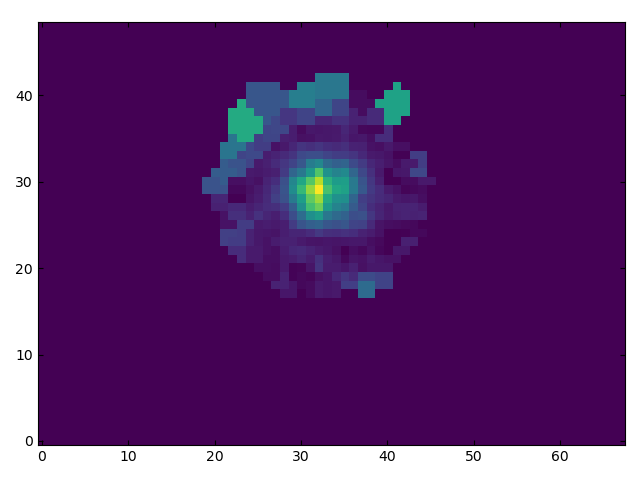

In [36]:
bfac_2D = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    if (b == -99):
        bf = 0.0
    else:
        bf = bfac[b]
    bfac_2D[data_vbin == b] = bf
        
fig, ax = plt.subplots()
ax.imshow(bfac_2D, origin = 'lower', vmin=0, vmax=1)
plt.tight_layout()
fits.writeto("bfac_2D.fits", bfac_2D, overwrite=True)

<IPython.core.display.Javascript object>


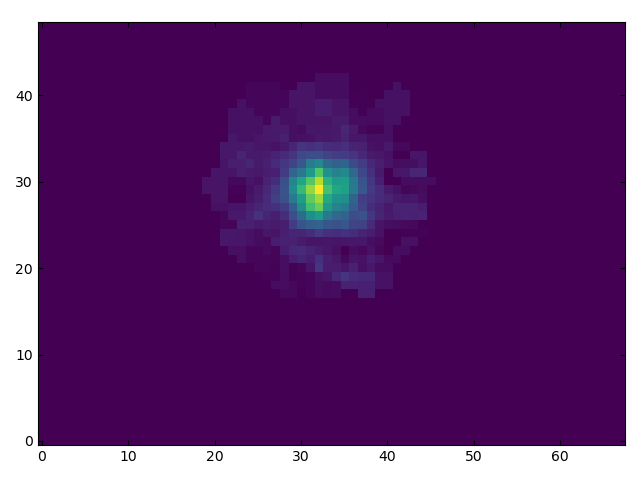

In [37]:
bfac_pix = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    if (b == -99):
        bf = 0.0
    else:
        bf = bfac[b]
    bfac_pix[data_vbin == b] = bf / np.sum(data_vbin == b)
        
fig, ax = plt.subplots()
ax.imshow(bfac_pix, origin = 'lower', vmin=0, vmax=1)
plt.tight_layout()
fits.writeto("bfac_pix.fits", bfac_pix, overwrite=True)